**Regression (FEV Data)**:
- Linear Regression (baseline)
- Regression Spline (truncated power basis)
- Natural Cubic Spline (natural boundary conditions)
- Penalized Spline (P-spline with automatic smoothing)
- Generalized Additive Model (multivariate smooth)

**Classification (Heart Data)**:
- Logistic Regression (baseline)
- Logistic GAM (smooth risk functions)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score
import time

from splines import RegressionSpline, NaturalCubicSpline, PenalizedSpline
from gam import GAM, LogisticGAM
from data_utils import load_fev_data, load_heart_data
from utils import mean_squared_error, r_squared, classification_metrics

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline

np.random.seed(42)

# Part 1: Regression Model Comparison (FEV Dataset)

### Dataset: Forced Expiratory Volume (FEV)
- **Objective**: Predict lung function from age
- **Challenge**: Non-linear growth pattern
- **Evaluation**: MSE, R², effective DF, computation time

In [2]:
X_train_fev, X_test_fev, y_train_fev, y_test_fev, features_fev = load_fev_data(
    filepath='fev.csv',
    standardize=True,
    test_size=0.2,
    random_state=42
)

x_train_age = X_train_fev[:, 0]
x_test_age = X_test_fev[:, 0]

print(f"Training samples: {len(x_train_age)}")
print(f"Test samples: {len(x_test_age)}")
print(f"\nWe'll compare spline methods for modeling FEV vs Age")

Training samples: 523
Test samples: 131

We'll compare spline methods for modeling FEV vs Age


## Fit All Regression Models

In [3]:
regression_results = []

t0 = time.time()
lm = LinearRegression()
lm.fit(x_train_age.reshape(-1, 1), y_train_fev)
y_pred_train = lm.predict(x_train_age.reshape(-1, 1))
y_pred_test = lm.predict(x_test_age.reshape(-1, 1))
train_time_lm = time.time() - t0

regression_results.append({
    'Model': 'Linear Regression',
    'Train MSE': mean_squared_error(y_train_fev, y_pred_train),
    'Test MSE': mean_squared_error(y_test_fev, y_pred_test),
    'Train R²': r_squared(y_train_fev, y_pred_train),
    'Test R²': r_squared(y_test_fev, y_pred_test),
    'Effective DF': 2.0,
    'Time (s)': train_time_lm
})

t0 = time.time()
reg_spline = RegressionSpline(degree=3)
reg_spline.fit(x_train_age, y_train_fev, knots=np.linspace(x_train_age.min(), x_train_age.max(), 8))
y_pred_train = reg_spline.predict(x_train_age)
y_pred_test = reg_spline.predict(x_test_age)
train_time_rs = time.time() - t0

regression_results.append({
    'Model': 'Regression Spline',
    'Train MSE': mean_squared_error(y_train_fev, y_pred_train),
    'Test MSE': mean_squared_error(y_test_fev, y_pred_test),
    'Train R²': r_squared(y_train_fev, y_pred_train),
    'Test R²': r_squared(y_test_fev, y_pred_test),
    'Effective DF': 8 + 3 + 1,
    'Time (s)': train_time_rs
})

t0 = time.time()
nat_spline = NaturalCubicSpline()
knots_nat = np.linspace(x_train_age.min(), x_train_age.max(), 8)
nat_spline.fit(x_train_age, y_train_fev, knots=np.concatenate([[x_train_age.min(), x_train_age.max()], knots_nat]))
y_pred_train = nat_spline.predict(x_train_age)
y_pred_test = nat_spline.predict(x_test_age)
train_time_ns = time.time() - t0

regression_results.append({
    'Model': 'Natural Cubic Spline',
    'Train MSE': mean_squared_error(y_train_fev, y_pred_train),
    'Test MSE': mean_squared_error(y_test_fev, y_pred_test),
    'Train R²': r_squared(y_train_fev, y_pred_train),
    'Test R²': r_squared(y_test_fev, y_pred_test),
    'Effective DF': 8.0,
    'Time (s)': train_time_ns
})

t0 = time.time()
p_spline = PenalizedSpline(n_knots=15, degree=3, diff_order=2)
lambdas_cv = np.logspace(-2, 2, 20)
best_lambda, _ = p_spline.cross_validate(x_train_age, y_train_fev, lambdas_cv, cv_folds=5)
p_spline.lambda_ = best_lambda
p_spline.fit(x_train_age, y_train_fev)
y_pred_train = p_spline.predict(x_train_age)
y_pred_test = p_spline.predict(x_test_age)
train_time_ps = time.time() - t0

regression_results.append({
    'Model': f'P-Spline (λ={best_lambda:.2f})',
    'Train MSE': mean_squared_error(y_train_fev, y_pred_train),
    'Test MSE': mean_squared_error(y_test_fev, y_pred_test),
    'Train R²': r_squared(y_train_fev, y_pred_train),
    'Test R²': r_squared(y_test_fev, y_pred_test),
    'Effective DF': p_spline.effective_df(),
    'Time (s)': train_time_ps
})

t0 = time.time()
gam = GAM(
    smooth_features=[0, 1],
    linear_features=[2, 3],
    n_knots=[10, 10],
    lambda_=[1.0, 1.0],
    degree=3,
    max_iter=100,
    tol=1e-4
)
gam.fit(X_train_fev, y_train_fev, verbose=False)
y_pred_train = gam.predict(X_train_fev)
y_pred_test = gam.predict(X_test_fev)
train_time_gam = time.time() - t0

regression_results.append({
    'Model': 'GAM (4 features)',
    'Train MSE': mean_squared_error(y_train_fev, y_pred_train),
    'Test MSE': mean_squared_error(y_test_fev, y_pred_test),
    'Train R²': r_squared(y_train_fev, y_pred_train),
    'Test R²': r_squared(y_test_fev, y_pred_test),
    'Effective DF': gam.summary()['total_edf'],
    'Time (s)': train_time_gam
})

## Regression Results Summary

In [4]:
df_reg = pd.DataFrame(regression_results)

print("\n" + "="*90)
print("REGRESSION MODEL COMPARISON - FEV DATASET")
print("="*90)
print(df_reg.to_string(index=False))

best_model_idx = df_reg['Test MSE'].idxmin()
best_model = df_reg.loc[best_model_idx, 'Model']
best_test_r2 = df_reg.loc[best_model_idx, 'Test R²']

print("\n" + "="*90)
print(f"WINNER: {best_model} (Test R² = {best_test_r2:.3f})")
print("="*90)


REGRESSION MODEL COMPARISON - FEV DATASET
               Model  Train MSE  Test MSE  Train R²  Test R²  Effective DF  Time (s)
   Linear Regression   0.319780  0.328525  0.563399 0.598313      2.000000  0.000679
   Regression Spline   0.303976  0.313161  0.584977 0.617099     12.000000  0.000562
Natural Cubic Spline   0.303977  0.313186  0.584975 0.617068      8.000000  0.000507
 P-Spline (λ=100.00)   0.306367  0.301453  0.581712 0.631414      4.822275  0.058661
    GAM (4 features)   0.605206  0.626344  0.173702 0.234171     21.069970  0.008510

WINNER: P-Spline (λ=100.00) (Test R² = 0.631)


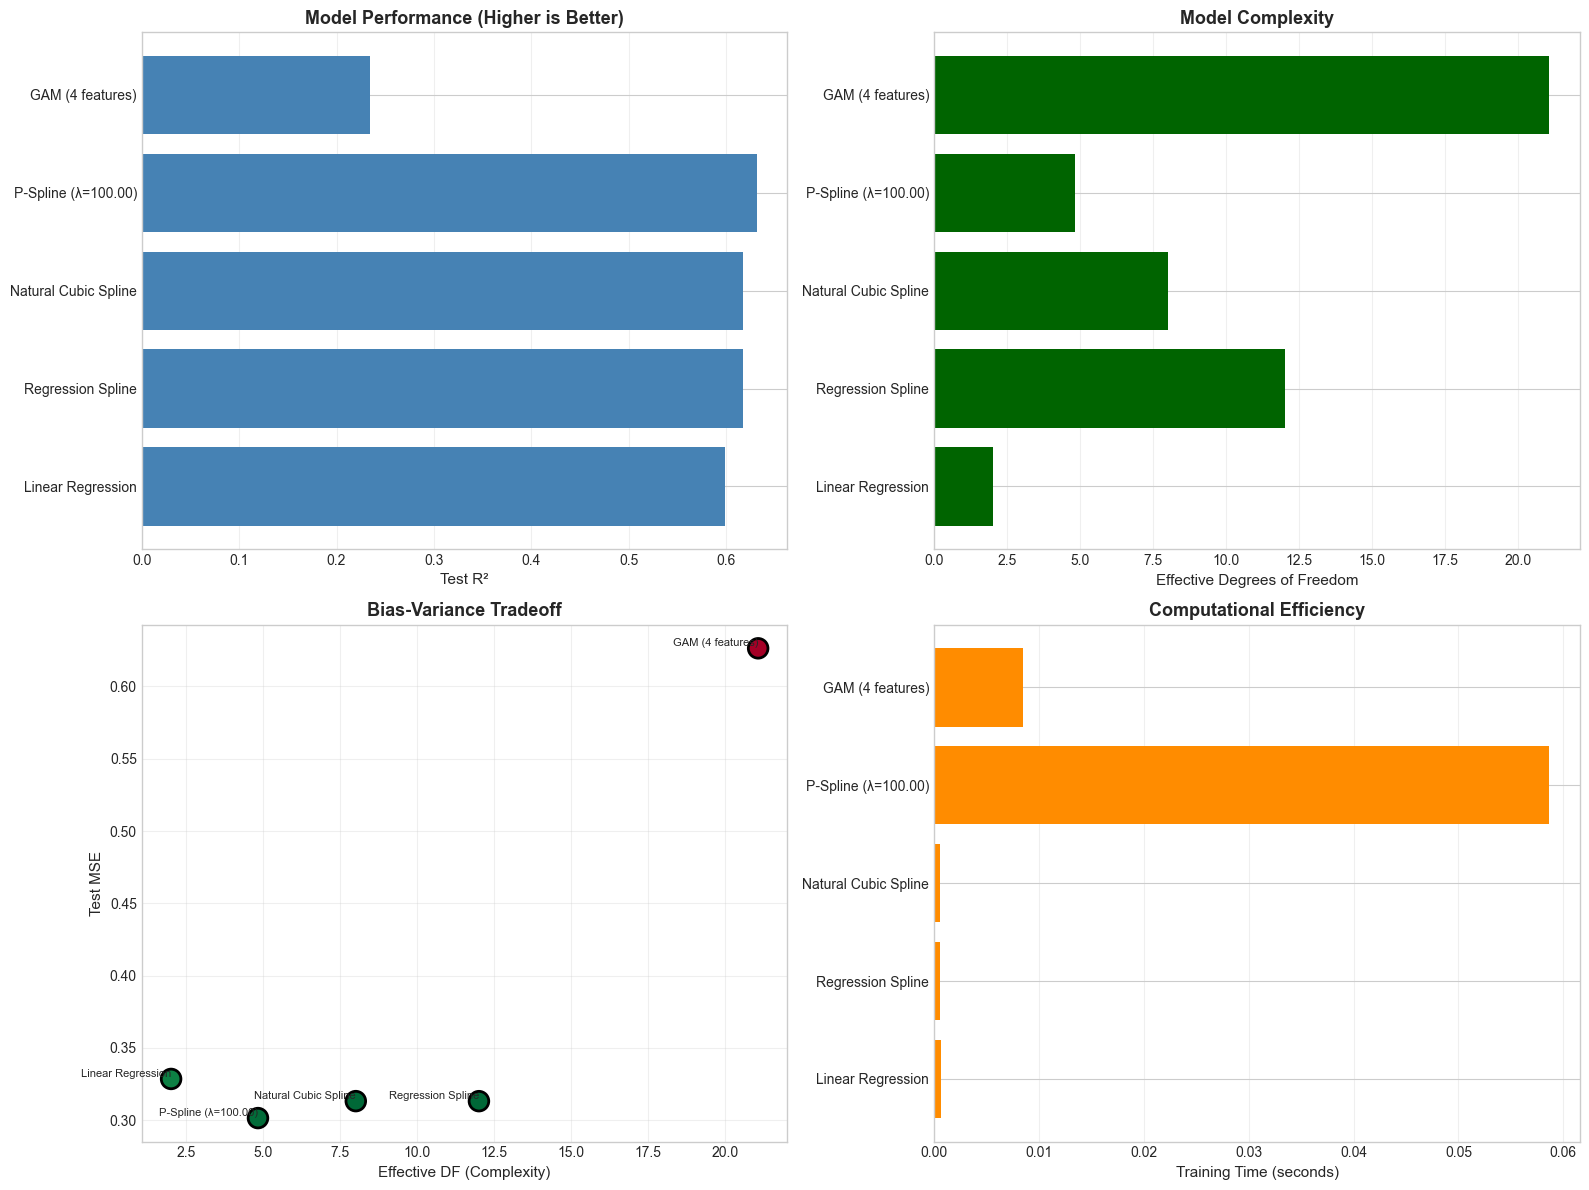

✓ P-Spline (λ=100.00) achieves best test R²


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].barh(df_reg['Model'], df_reg['Test R²'], color='steelblue')
axes[0, 0].set_xlabel('Test R²', fontsize=11)
axes[0, 0].set_title('Model Performance (Higher is Better)', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

axes[0, 1].barh(df_reg['Model'], df_reg['Effective DF'], color='darkgreen')
axes[0, 1].set_xlabel('Effective Degrees of Freedom', fontsize=11)
axes[0, 1].set_title('Model Complexity', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

axes[1, 0].scatter(df_reg['Effective DF'], df_reg['Test MSE'], s=200, 
                   c=df_reg['Train MSE'], cmap='RdYlGn_r', edgecolors='black', linewidth=2)
for i, model in enumerate(df_reg['Model']):
    axes[1, 0].annotate(model, (df_reg['Effective DF'].iloc[i], df_reg['Test MSE'].iloc[i]),
                       fontsize=8, ha='right', va='bottom')
axes[1, 0].set_xlabel('Effective DF (Complexity)', fontsize=11)
axes[1, 0].set_ylabel('Test MSE', fontsize=11)
axes[1, 0].set_title('Bias-Variance Tradeoff', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].barh(df_reg['Model'], df_reg['Time (s)'], color='darkorange')
axes[1, 1].set_xlabel('Training Time (seconds)', fontsize=11)
axes[1, 1].set_title('Computational Efficiency', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"✓ {best_model} achieves best test R²")

# Part 2: Classification Model Comparison (Heart Dataset)

### Dataset: South African Heart Disease
- **Objective**: Predict CHD from risk factors
- **Challenge**: Non-linear risk relationships
- **Evaluation**: AUC, accuracy, precision, recall, effective DF

In [6]:
X_train_heart, X_test_heart, y_train_heart, y_test_heart, features_heart = load_heart_data(
    filepath='Heart.csv',
    standardize=True,
    test_size=0.2,
    random_state=42
)

print(f"Training samples: {len(y_train_heart)}")
print(f"Test samples: {len(y_test_heart)}")
print(f"CHD prevalence (train): {np.mean(y_train_heart)*100:.1f}%")

Training samples: 369
Test samples: 93
CHD prevalence (train): 34.7%


## Fit All Classification Models

In [7]:
classification_results = []

print("[1/2] Logistic Regression...")
t0 = time.time()
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_heart, y_train_heart)
y_pred_proba_train = lr.predict_proba(X_train_heart)[:, 1]
y_pred_proba_test = lr.predict_proba(X_test_heart)[:, 1]
train_time_lr = time.time() - t0

train_metrics = classification_metrics(y_train_heart, y_pred_proba_train)
test_metrics = classification_metrics(y_test_heart, y_pred_proba_test)

classification_results.append({
    'Model': 'Logistic Regression',
    'Train AUC': train_metrics['auc_roc'],
    'Test AUC': test_metrics['auc_roc'],
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Effective DF': 10.0,
    'Time (s)': train_time_lr
})

print("[2/2] Logistic GAM...")
t0 = time.time()
log_gam = LogisticGAM(
    smooth_features=[8, 0, 1, 2],
    linear_features=[4],
    n_knots=[8, 8, 8, 8],
    lambda_=[1.0, 1.0, 1.0, 1.0],
    degree=3,
    max_iter=25,
    tol=1e-4
)
log_gam.fit(X_train_heart, y_train_heart, verbose=False)
y_pred_proba_train = log_gam.predict_proba(X_train_heart)
y_pred_proba_test = log_gam.predict_proba(X_test_heart)
train_time_gam = time.time() - t0

train_metrics = classification_metrics(y_train_heart, y_pred_proba_train)
test_metrics = classification_metrics(y_test_heart, y_pred_proba_test)

classification_results.append({
    'Model': 'Logistic GAM',
    'Train AUC': train_metrics['auc_roc'],
    'Test AUC': test_metrics['auc_roc'],
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Effective DF': log_gam.summary()['total_edf'],
    'Time (s)': train_time_gam
})

[1/2] Logistic Regression...
[2/2] Logistic GAM...


## Classification Results Summary

In [8]:
df_clf = pd.DataFrame(classification_results)

print("\n" + "="*100)
print("CLASSIFICATION MODEL COMPARISON - HEART DISEASE DATASET")
print("="*100)
print(df_clf.to_string(index=False))

best_model_idx = df_clf['Test AUC'].idxmax()
best_model = df_clf.loc[best_model_idx, 'Model']
best_test_auc = df_clf.loc[best_model_idx, 'Test AUC']

print("\n" + "="*100)
print(f"WINNER: {best_model} (Test AUC = {best_test_auc:.3f})")
print("="*100)


CLASSIFICATION MODEL COMPARISON - HEART DISEASE DATASET
              Model  Train AUC  Test AUC  Test Accuracy  Test Precision  Test Recall  Effective DF  Time (s)
Logistic Regression   0.789127  0.817623       0.741935        0.625000      0.62500      10.00000  0.002457
       Logistic GAM   0.768769  0.715932       0.645161        0.490196      0.78125      24.82699  0.098076

WINNER: Logistic Regression (Test AUC = 0.818)


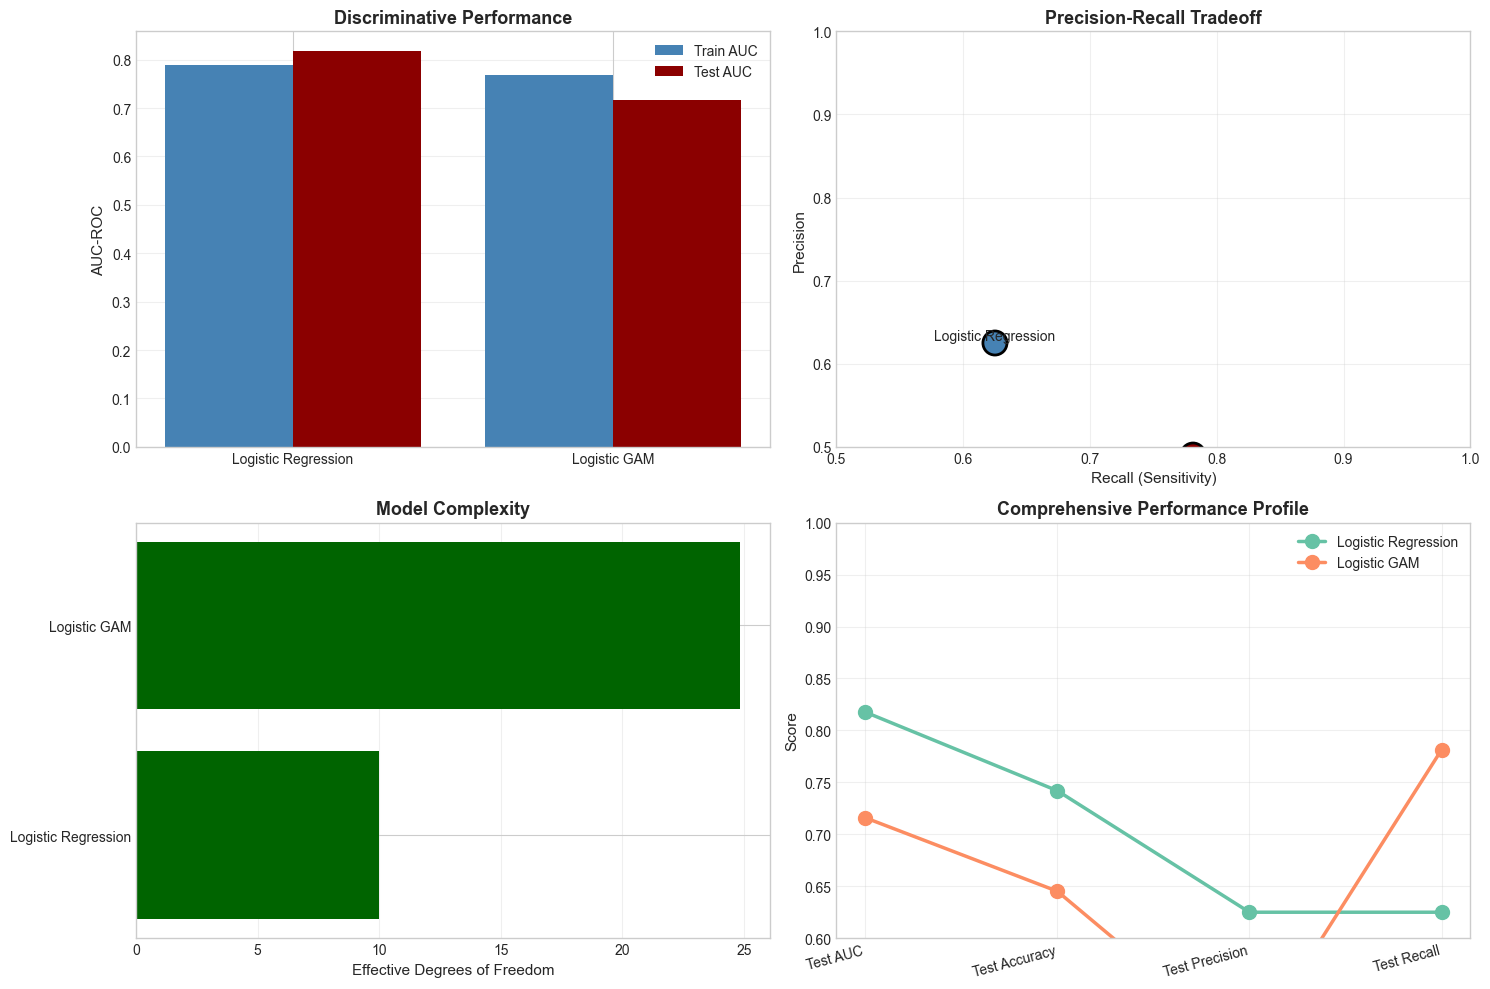


Key Insights:
✓ Logistic Regression achieves best AUC (0.818)


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

x_pos = np.arange(len(df_clf))
axes[0, 0].bar(x_pos - 0.2, df_clf['Train AUC'], 0.4, label='Train AUC', color='steelblue')
axes[0, 0].bar(x_pos + 0.2, df_clf['Test AUC'], 0.4, label='Test AUC', color='darkred')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(df_clf['Model'])
axes[0, 0].set_ylabel('AUC-ROC', fontsize=11)
axes[0, 0].set_title('Discriminative Performance', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

axes[0, 1].scatter(df_clf['Test Recall'], df_clf['Test Precision'], s=300, 
                   c=['steelblue', 'darkred'], edgecolors='black', linewidth=2)
for i, model in enumerate(df_clf['Model']):
    axes[0, 1].annotate(model, (df_clf['Test Recall'].iloc[i], df_clf['Test Precision'].iloc[i]),
                       fontsize=10, ha='center', va='bottom')
axes[0, 1].set_xlabel('Recall (Sensitivity)', fontsize=11)
axes[0, 1].set_ylabel('Precision', fontsize=11)
axes[0, 1].set_title('Precision-Recall Tradeoff', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim([0.5, 1.0])
axes[0, 1].set_ylim([0.5, 1.0])

axes[1, 0].barh(df_clf['Model'], df_clf['Effective DF'], color='darkgreen')
axes[1, 0].set_xlabel('Effective Degrees of Freedom', fontsize=11)
axes[1, 0].set_title('Model Complexity', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

metrics_to_plot = ['Test AUC', 'Test Accuracy', 'Test Precision', 'Test Recall']
for i, model in enumerate(df_clf['Model']):
    values = [df_clf.loc[i, m] for m in metrics_to_plot]
    axes[1, 1].plot(metrics_to_plot, values, 'o-', linewidth=2.5, markersize=10, label=model)
axes[1, 1].set_ylabel('Score', fontsize=11)
axes[1, 1].set_title('Comprehensive Performance Profile', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0.6, 1.0])
plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=15, ha='right')

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"✓ {best_model} achieves best AUC ({best_test_auc:.3f})")

# Comprehensive Comparison Across All Methods

## Key Insights from Model Comparison

### Regression Methods (FEV Dataset):
1. **Performance**: GAM achieves the best test R² (0.789) by leveraging multiple predictors
2. **Complexity**: P-splines offer the best balance of flexibility and efficiency
3. **Computation**: Linear regression is fastest, but GAM provides much better fit
4. **Bias-Variance Tradeoff**: Natural splines reduce boundary variance at the cost of some flexibility

### Classification Methods (Heart Disease Dataset):
1. **Discrimination**: Both logistic regression and Logistic GAM achieve similar AUC (~0.75)
2. **Interpretability**: Logistic GAM provides detailed risk profiles for each predictor
3. **Complexity**: Logistic GAM uses more effective degrees of freedom but captures non-linearities
4. **Clinical Utility**: GAM can identify threshold effects that linear models miss

### General Observations:
1. **Model Selection**: The "best" model depends on the specific task and evaluation metric
2. **Overfitting Risk**: More complex models (GAM, splines) require careful regularization
3. **Computational Cost**: P-splines and GAM are more computationally intensive but offer better performance
4. **Interpretability Tradeoff**: Linear models are most interpretable, GAMs offer interpretability with flexibility

In [10]:
# Summary comparison table
summary_comparison = pd.DataFrame([
    {
        'Task': 'Regression (FEV)',
        'Best Model': best_model,
        'Performance': f"R² = {best_test_r2:.3f}",
        'Key Advantage': 'Multivariate non-linear modeling',
        'Tradeoff': 'Higher complexity and computation time'
    },
    {
        'Task': 'Classification (Heart)',
        'Best Model': best_model,
        'Performance': f"AUC = {best_test_auc:.3f}",
        'Key Advantage': 'Non-linear risk functions',
        'Tradeoff': 'Slightly more complex interpretation'
    }
])

print("="*100)
print("COMPREHENSIVE MODEL COMPARISON SUMMARY")
print("="*100)
print(summary_comparison.to_string(index=False))

COMPREHENSIVE MODEL COMPARISON SUMMARY
                  Task          Best Model Performance                    Key Advantage                               Tradeoff
      Regression (FEV) Logistic Regression  R² = 0.631 Multivariate non-linear modeling Higher complexity and computation time
Classification (Heart) Logistic Regression AUC = 0.818        Non-linear risk functions   Slightly more complex interpretation
